<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_46).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Esperanza de vida)](#Analisis-por-grupo-de-indicadores-(esperanza-de-vida))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Esperanza de vida)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','AñosEspVida']]

In [5]:
df_var = df_sel.dropna()

In [6]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4968 entries, 0 to 5255
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4968 non-null   int64  
 1   Trimestre             4968 non-null   int64  
 2   Mes                   4968 non-null   int64  
 3   Codi_Districte        4968 non-null   int64  
 4   Nom_Districte         4968 non-null   object 
 5   Codi_Barri            4968 non-null   int64  
 6   Nom_Barri             4968 non-null   object 
 7   Compraventa_Unitario  4968 non-null   float64
 8   AñosEspVida           4968 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 388.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_var['Fecha'] = pd.to_datetime(df_var['Any'].astype(str) + '-' + df_var['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_varI = df_var.set_index('Fecha')

In [9]:
df_varI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,AñosEspVida
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,80.7
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,80.7


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarrià-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_varFiltrado = df_varI[df_varI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df =df_varFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-01-01,4198.150000,84.416667
2014-02-01,4198.150000,84.416667
2014-03-01,4198.150000,84.416667
2014-04-01,4246.083333,84.416667
2014-05-01,4246.083333,84.416667


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  72 non-null     float64
 1   AñosEspVida           72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB


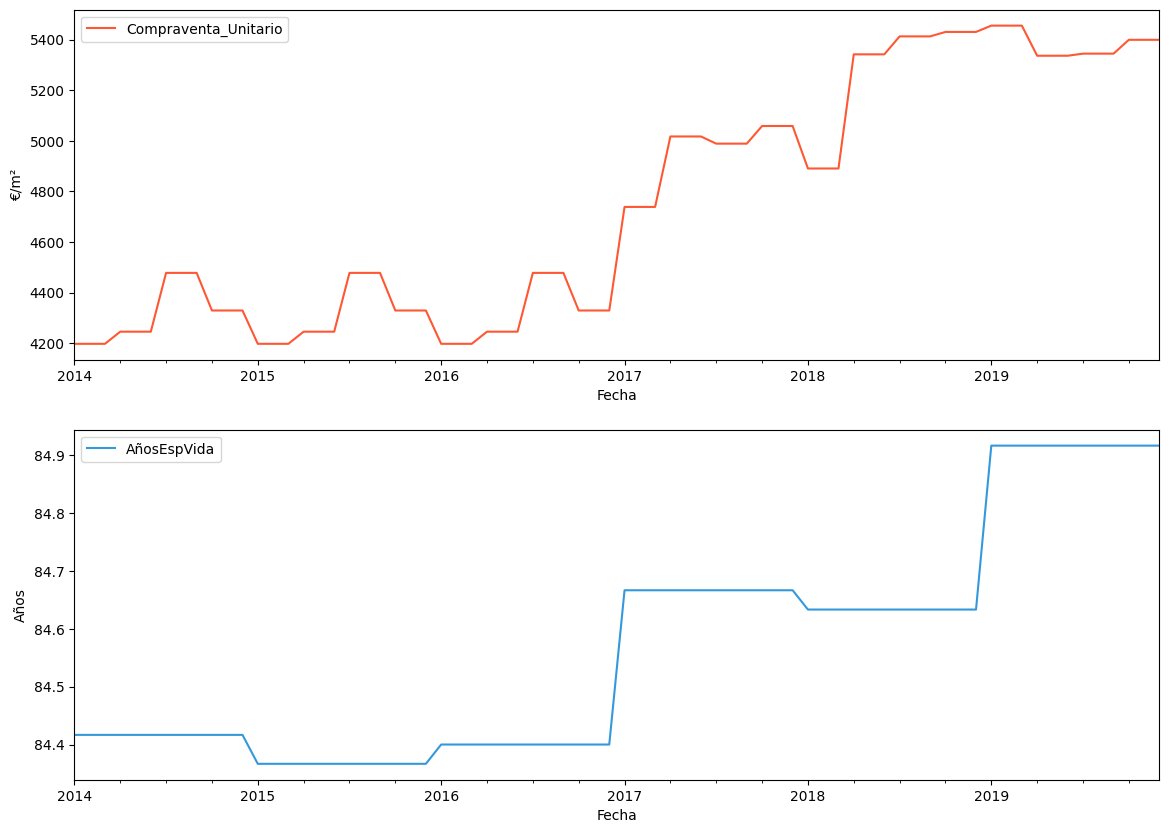

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'Años']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,AñosEspVida
Compraventa_Unitario,1.000000,0.895532
AñosEspVida,0.895532,1.000000


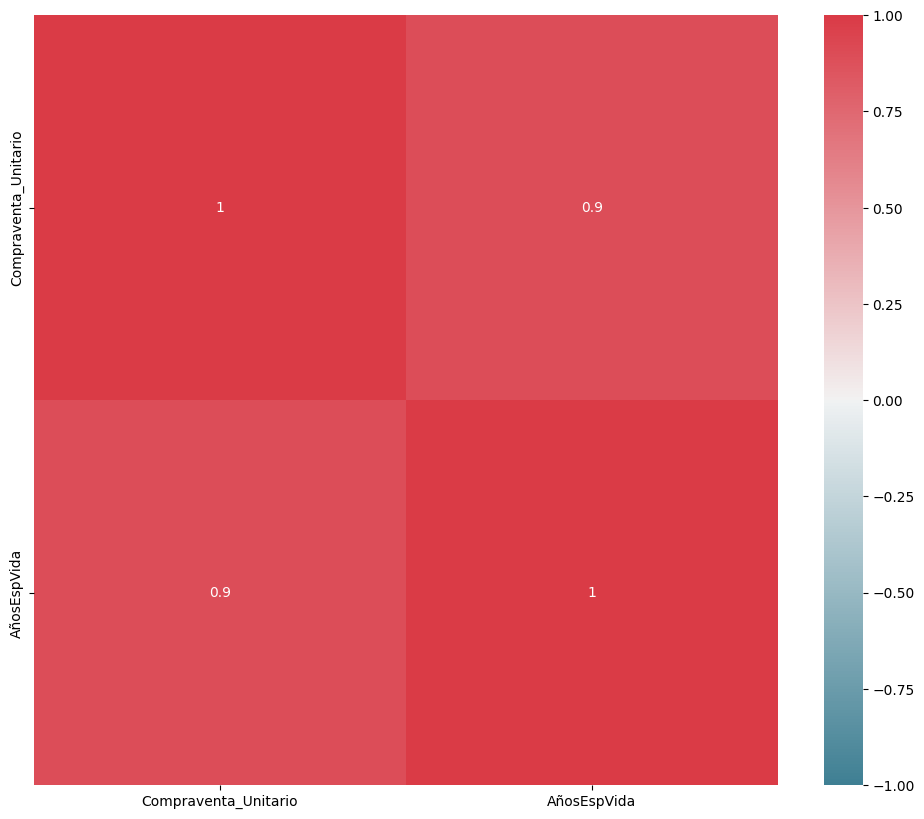

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen una alta correlacion, concretamente un 89.5532% de correlacion

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2019-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(60, 2) (12, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [18]:
import statsmodels.tsa.stattools as sts

In [19]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.913691
Serie de tiempo AñosEspVida
p-value: 0.790090


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [20]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,47.933333,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


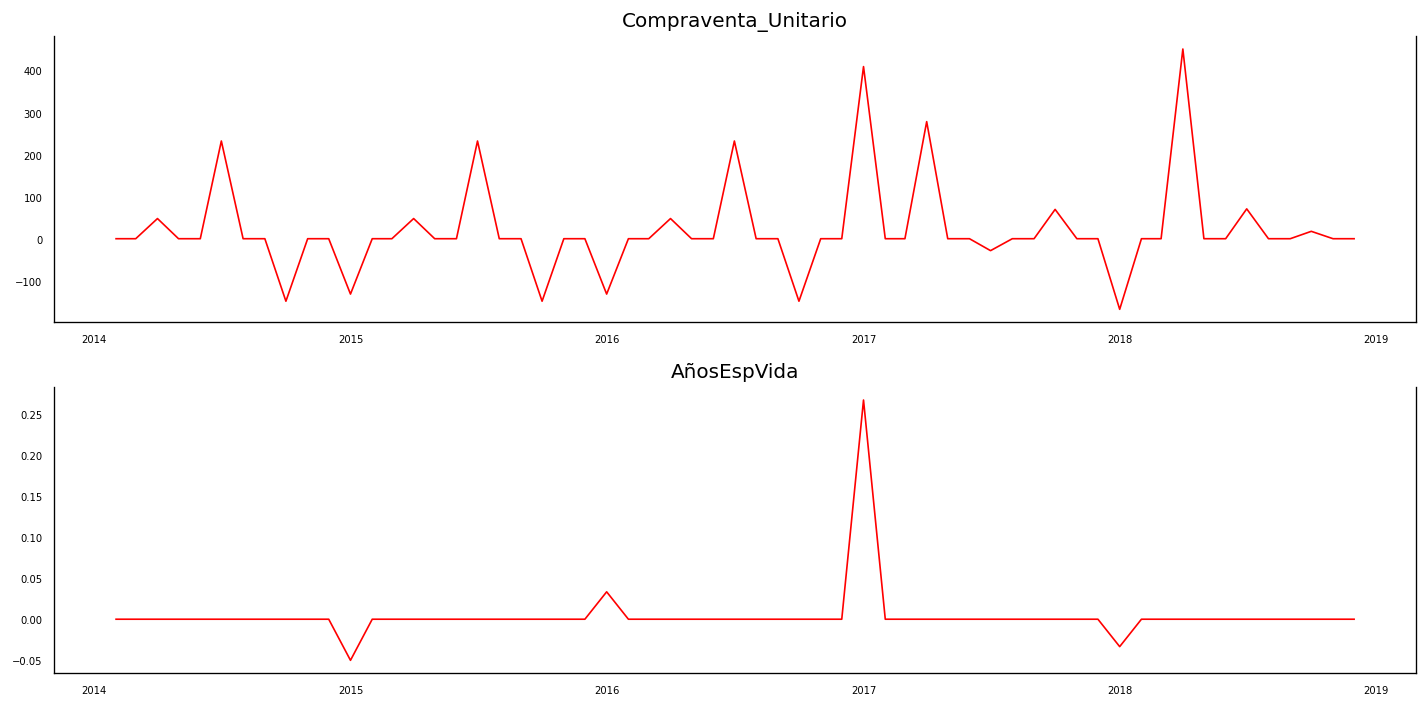

In [21]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [22]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable AñosEspVida
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

In [23]:
from statsmodels.tsa.api import VAR

In [24]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [28]:
modelsel=model.select_order(17)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,3.062,3.144*,21.36,3.092
1,3.249,3.497,25.78,3.340
2,3.436,3.850,31.13,3.588
3,3.412,3.991,30.51,3.624
4,3.594,4.339,36.89,3.867
5,3.775,4.685,44.71,4.109
6,3.806,4.882,46.90,4.200
7,3.991,5.232,57.77,4.445
8,4.174,5.581,71.70,4.690
9,4.171,5.744,74.63,4.748


La selección del orden VAR destaca el mínimo en AIC y BIC, que corresponde a un modelo con un orden de 17. Este modelo proporciona el AIC más bajo de todas las opciones consideradas, lo que sugiere que es el mejor ajuste en términos de complejidad y capacidad explicativa. Además, el FPE también es relativamente bajo en este orden, lo que indica que el modelo es adecuado para explicar la variabilidad en los datos.

Para este caso adoptamos VAR(12)

#### Ajustando el modelo

In [65]:
res = model.fit(maxlags=12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     15:48:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.35246
Nobs:                     47.0000    HQIC:                   3.12488
Log likelihood:          -139.409    FPE:                    13.8433
AIC:                      2.38421    Det(Omega_mle):         5.89889
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           31.012920        26.321057            1.178           0.239
L1.Compraventa_Unitario         -0.081386         0.220282           -0.369           0.712
L

La correlación entre los residuos de "Compraventa_Unitario" y "AñosEspVida" es bastante alta, con un valor de 0.914434. Esto sugiere una correlación muy fuerte entre los residuos de estas dos variables en tu modelo.

In [51]:
X_train.columns

Index(['Compraventa_Unitario', 'AñosEspVida'], dtype='object')

###### Causalidad de Granger

In [66]:
grangercaus=res.test_causality(['AñosEspVida'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9155,1.980,0.540,"(12, 44)"


In [67]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['AñosEspVida'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9665,1.980,0.494,"(12, 44)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede causar la otra serie temporal

###### Matriz de causalidad de Granger


In [70]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,AñosEspVida_x
Compraventa_Unitario_y,1.000,0.0159
AñosEspVida_y,0.024,1.0000


Como se puede ver en la matriz de causalidad de Granger, podemos considerar que la serie de Compraventa_Unitario causa cambios en la serie de AñosEspVida y viceversa.

###### Diagnosis del modelo


###### Residuos

In [71]:
residuals=res.resid

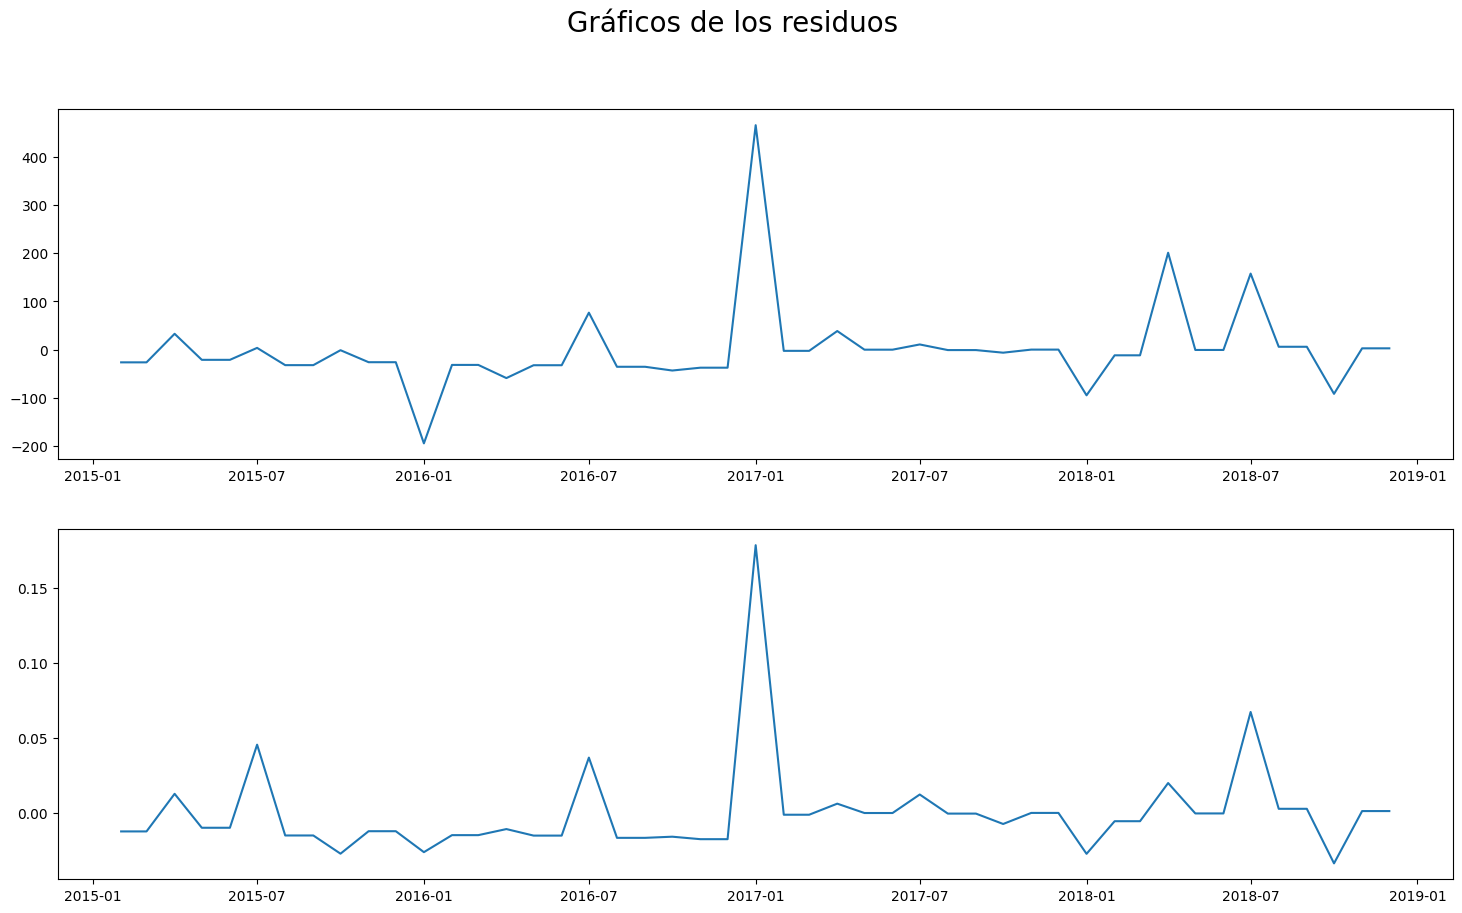

In [72]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [73]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[4.922232887193465e-09, 1.2213092045489763e-09]

Todos los p-valores son < 0.05 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


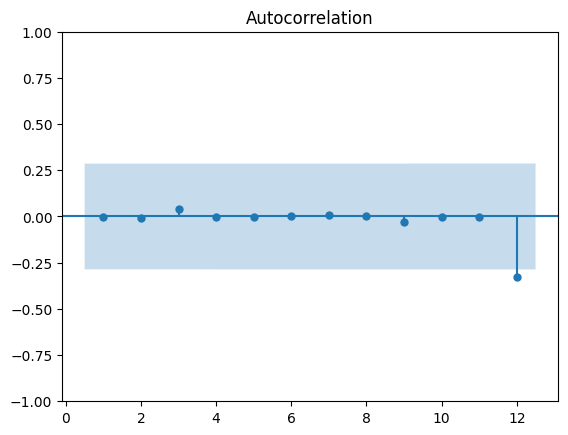

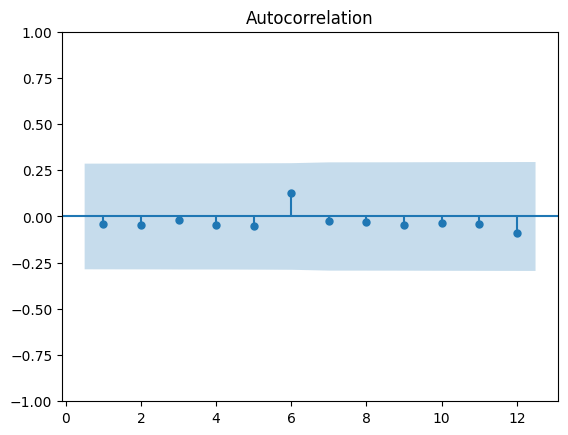

In [74]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


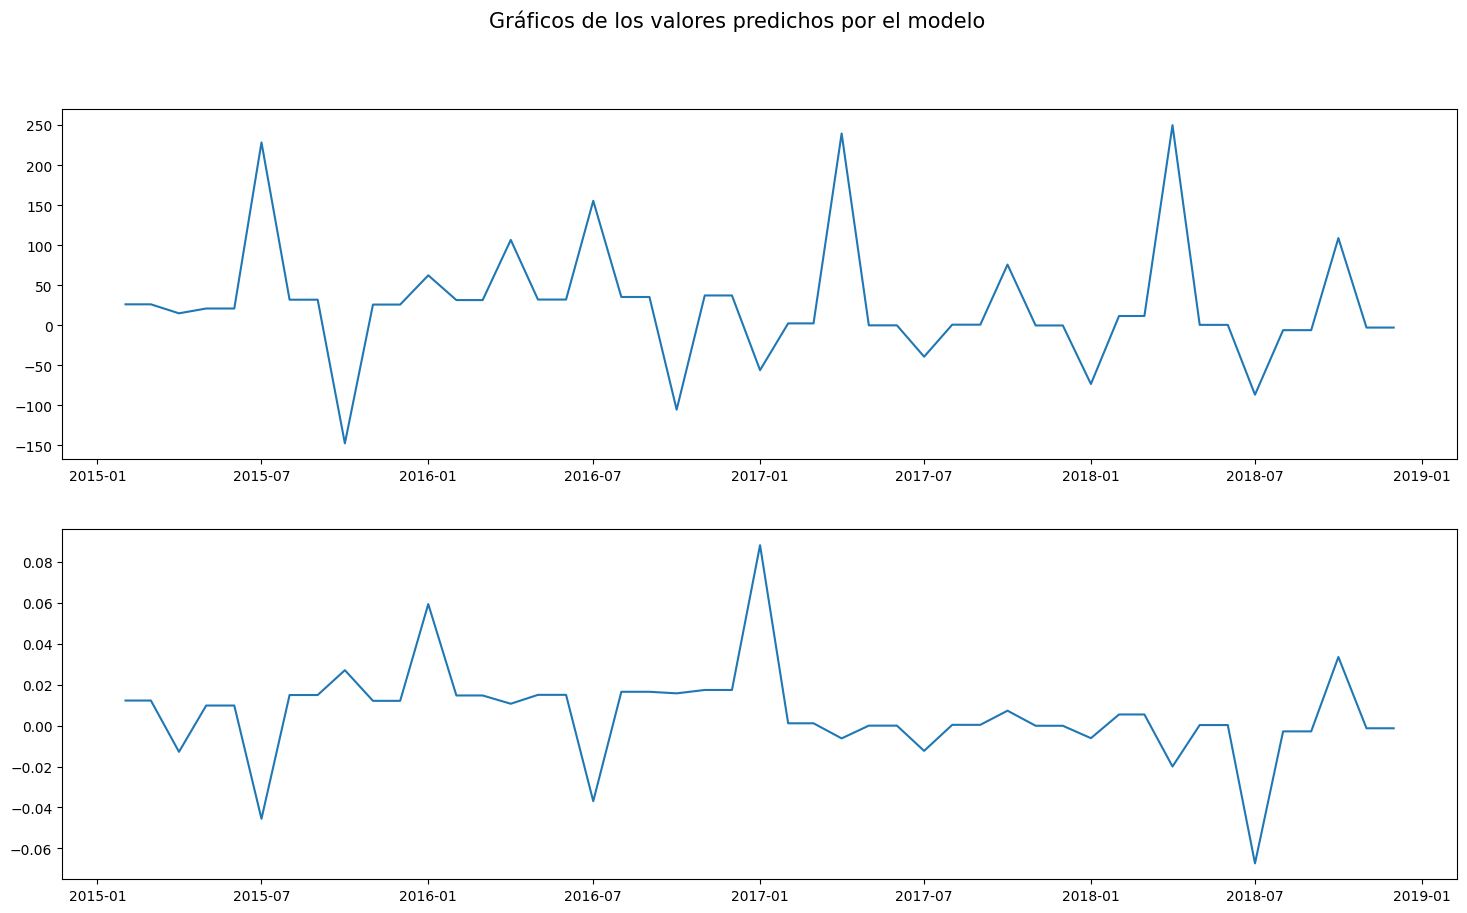

In [75]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [76]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,AñosEspVida_pred
Fecha,,
2019-01-01,-61.996196,0.012768
2019-02-01,-15.231475,-0.007111
2019-03-01,-14.445244,-0.006744
2019-04-01,396.970860,-0.067114
2019-05-01,-10.832605,-0.002707
2019-06-01,-10.338035,-0.002598
2019-07-01,-97.915713,-0.082587
2019-08-01,0.842514,-0.002308
2019-09-01,0.982644,-0.002094


<Figure size 1200x1000 with 0 Axes>

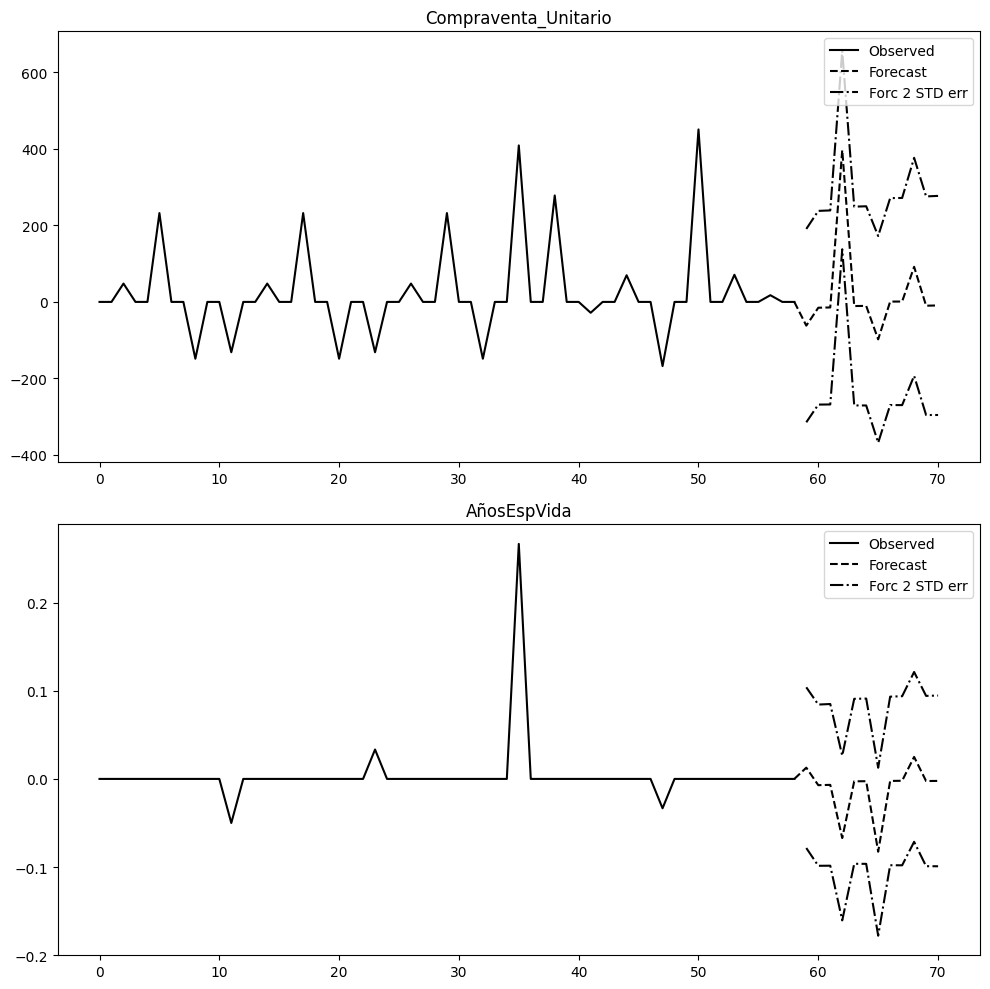

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [78]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [79]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,AñosEspVida
Fecha,,
2019-01-01,5368.270471,84.646101
2019-02-01,5353.038996,84.638991
2019-03-01,5338.593751,84.632247
2019-04-01,5735.564612,84.565134
2019-05-01,5724.732007,84.562426
2019-06-01,5714.393972,84.559829
2019-07-01,5616.478259,84.477242
2019-08-01,5617.320773,84.474934
2019-09-01,5618.303417,84.472840


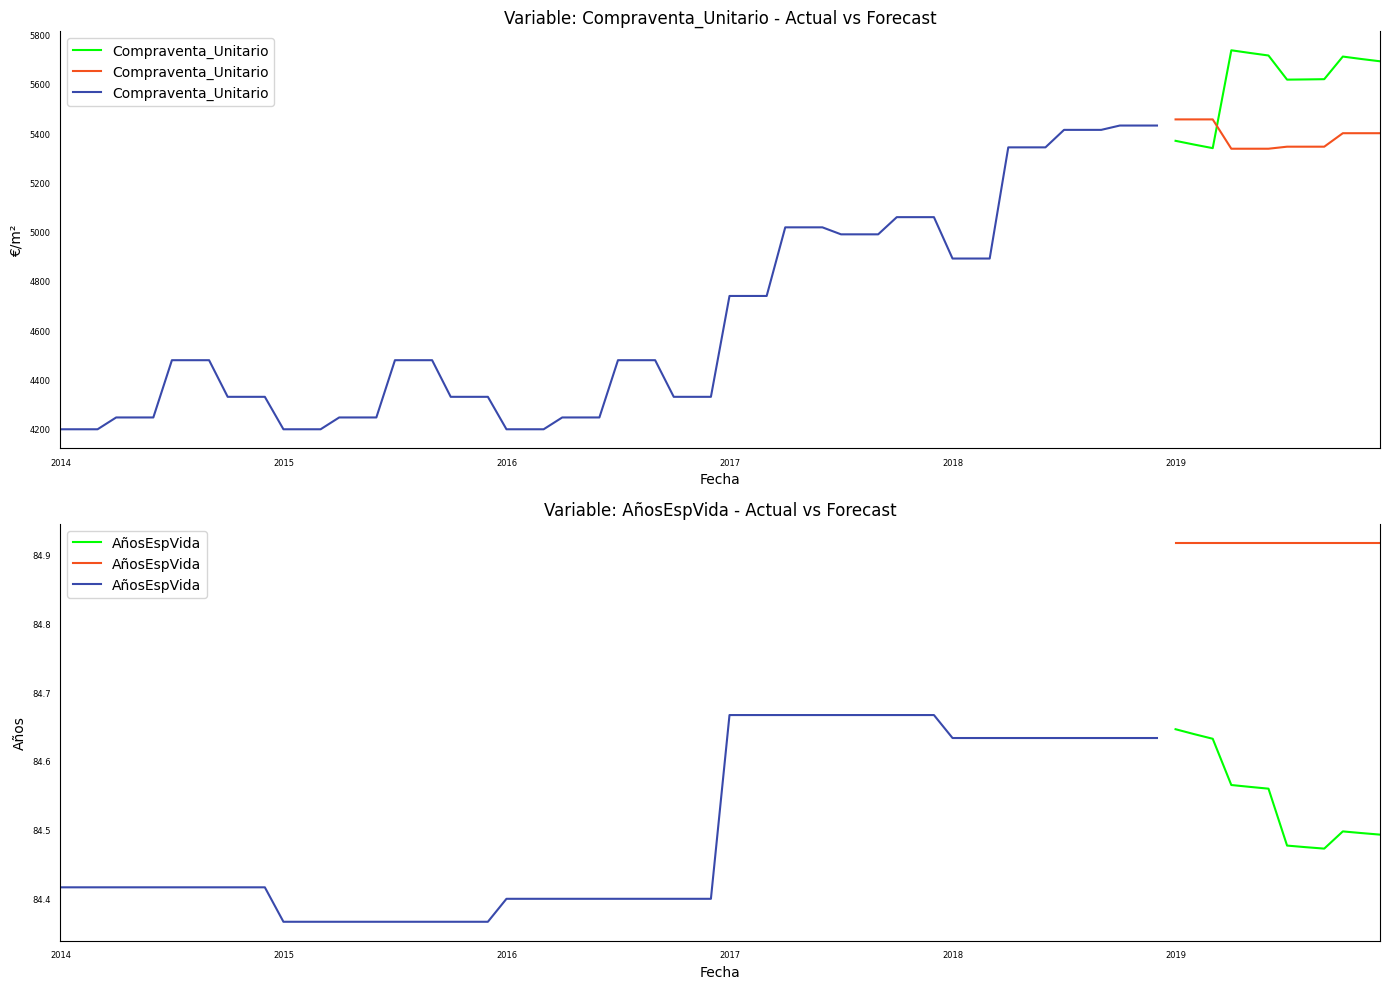

In [80]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Años']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [81]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [82]:
for i in ['Compraventa_Unitario','AñosEspVida']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 81731.14955809923
MAE is : 266.1604566534249
RMSE is : 285.886602620863
MAPE is : 4.958963933307
R2 is : -34.78261461458675

Evaluation metric for AñosEspVida
Evaluation metric results:-
MSE is : 0.14375556224026734
MAE is : 0.37365710809674013
RMSE is : 0.37915110739686275
MAPE is : 0.4400279977586733
R2 is : -7.118430654688339e+26



Los resultados muestran un rendimiento deficiente en la predicción de ambas variables. Para "Compraventa_Unitario", el modelo muestra una discrepancia significativa, con un error cuadrático medio (MSE) bastante alto y un coeficiente de determinación (R2) negativo, lo que indica que el modelo no se ajusta bien a los datos y puede estar sobreajustado. Para "AñosEspVida", aunque el MSE y el R2 son extremadamente altos y negativos, lo que indica un ajuste deficiente, el error absoluto medio (MAE) y el error absoluto porcentual medio (MAPE) son más bajos en comparación con "Compraventa_Unitario".

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 133.2670568807608
Root mean squared error: 202.15253314472895


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [84]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [85]:
fecha_division = '2019-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(60, 2) (12, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [86]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.913691
Serie de tiempo AñosEspVida
p-value: 0.790090


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [87]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,47.933333,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


In [88]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable AñosEspVida
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [89]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [90]:
cointegration_test(X_train_transformed[['Compraventa_Unitario', 'AñosEspVida']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  23.32     > 12.3212   =>   True
AñosEspVida >  6.54      > 4.1296    =>   True


Los resultados del test de Cointegracion entre las dos series temporales son satisfactorios.

Para "Compraventa_Unitario", el valor del estadístico de prueba es 23.32, lo cual es mucho mayor que el valor crítico de 12.3212 al 95% de confianza. Esto indica que hay evidencia significativa de cointegración para esta variable.

Para "Participacion", el valor del estadístico de prueba es 21.23, nuevamente mucho mayor que el valor crítico de 6.54 al 95% de confianza. Esto también indica que hay evidencia significativa de cointegración para esta variable.

A pesar de las fluctuaciones a corto plazo, ambas variables tienden a moverse juntas en el largo plazo. Esto es importante para la modelización y el análisis de series temporales, ya que proporciona información sobre la relación a largo plazo entre las variables y puede ayudar en la construcción de modelos más precisos y en la formulación de políticas adecuadas.

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [91]:
import pmdarima as pm

In [92]:

pq = []
for name in ['Compraventa_Unitario', 'AñosEspVida']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=727.557, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=729.557, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=729.557, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=731.557, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=727.517, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=729.443, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=729.437, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=731.437, Time=0.35 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.973 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : AñosEspVida
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-223.314, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-221.314, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]       

#####Seleccion del modelo

In [94]:
pq

[(0, 0, 0), (0, 0, 0)]

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMAX, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.

Por lo que para estos datos, no es posible entrenar un modelo VARMAX

##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Sarrià-Sant Gervasi** de Barcelona entre las dos series temporales de Compraventa_unitario y Años de esperanza de vida, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del segundo orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido muy pisitiva, lo que quiere decir que una serie temporal puede causar la otra serie temporal. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado positivo, lo que significa que las series estan relacionadas en el tiempo y que serie estos datos pueden ser aptos para este modelo

El modelo VARMAX para estos datos, ha dado muy buenos resultados.

